In [ ]:
#EXPLANATION of the files for the #https://cddis.nasa.gov/archive/gnss/products/ionex/

'''
1. Understanding the Files

IONEX Files: (Global TEC Grids)
These are what you want for Daily Global VTEC in the standard IONEX format:

c1pg0200.24i.Z
c2pg0200.24i.Z
casg0200.24i.Z
uhrg0200.24i.Z
upcg0200.24i.Z
uprg0200.24i.Z
uqrg0200.24i.Z

These are in IONEX format

File naming breakdown:

c1pg0200.24i.Z:

c1p = CODE (analysis center)
g = global
020 = day-of-year
0 = version or type
.24i.Z = IONEX for 2024, compressed

Similarly:

uqrg0200.24i.Z: UPC Rapid GIM
upcg0200.24i.Z: UPC CODE-like GIM
uprg0200.24i.Z: UPC Rapid variant



GIM.INX Files: (Metadata, often auxiliary)
These are compressed files that contain metadata or index content about the gridded data, not TEC values themselves:

COD0OPSFIN_20240200000_01D_01H_GIM.INX.gz
UPC0OPSRAP_20240200000_01D_15M_GIM.INX.gz
...
Useful if:

You're verifying file availability, time resolution, and data source

You need accompanying metadata, but not actual TEC values



ROTI File (TEC fluctuations)

IGS0OPSFIN_20240200000_01D_01D_ROT.INX.gz
This contains Rate of TEC Index (ROTI) — a measure of TEC variability and ionospheric scintillation. Useful for ionospheric disturbance analysis.
'''

#For each year, We should dowload file with the name uqrgDD00.24i.Z or if not present upcg0200.24i.Z

In [ ]:
import requests
import netrc
import os
from urllib.parse import urlparse
from bs4 import BeautifulSoup
import subprocess

# ==== Configuration ====
start_year = 2023
end_year = 2024
base_url = "https://cddis.nasa.gov/archive/gnss/products/ionex"
save_dir = "/home/simone/Desktop/PhD/fdl/datasets/vtec_data"
desired_prefix = "uqrg"  # or "upcg" if you want the CODE-like GIM
# ======================

os.makedirs(save_dir, exist_ok=True)

try: 
    auth_data = netrc.netrc()
    username, _, password = auth_data.authenticators("urs.earthdata.nasa.gov")
except FileNotFoundError:
    raise RuntimeError("No .netrc file found. Please create one with your Earthdata credentials.")
except TypeError:
    raise RuntimeError("Please set up your .netrc file with Earthdata credentials.")


# Start session - ATTENTION: COMMENT PRINT STATEMENT AFTER TESTING
with requests.Session() as session:
    session.auth = (username, password)
    session.headers.update({'User-Agent': 'simone-ionex-script/1.0'})

    for year in range(start_year, end_year + 1):
        year_short = str(year)[-2:]

        for doy in range(1,367):
            doy_str = f"{doy:03d}"  # Format day of year as three digits
            file_name = f"{desired_prefix}{doy_str}0.{year_short}i.Z"
            folder_url = f"{base_url}/{year}/{doy_str}/"
            file_url = folder_url + file_name
            
            print(f"Trying to download {file_name} from {file_url}")

            #response = session.get(folder_url)
            response = session.get(file_url)

            if response.status_code == 200:
                local_path = os.path.join(save_dir, file_name)
                with open(local_path, 'wb') as file:
                    file.write(response.content)
                print(f"Downloaded {file_name} to {local_path}")


                try:
                    subprocess.run(['uncompress', local_path], check=True)
                    print(f"Uncompressed {file_name} successfully.")
                except subprocess.CalledProcessError as e:
                    print(f"Failed to uncompress {file_name}: {e}")
                except FileNotFoundError:
                    print("Uncompress command not found. Please install 'uncompress' utility.")
                        

            else:
                print(f"File {file_name} not found at {file_url}. Status code: {response.status_code}")
                continue
            

In [5]:
import os
import re
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

def parse_ionex_to_dataframe(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()

    header_end = [i for i, l in enumerate(lines) if 'END OF HEADER' in l][0]
    header = lines[:header_end]

    for line in header:
        if 'LAT1 / LAT2 / DLAT' in line:
            lat1, lat2, dlat = map(float, line.split()[:3])
        if 'LON1 / LON2 / DLON' in line:
            lon1, lon2, dlon = map(float, line.split()[:3])

    lats = np.arange(lat1, lat2 - 0.1, -abs(dlat))  # top-to-bottom
    lons = np.arange(lon1, lon2 + 0.1, dlon)

    maps = []
    epochs = []

    i = header_end + 1
    while i < len(lines):
        if 'START OF TEC MAP' in lines[i]:
            epoch_line = lines[i+1]
            y, mo, d, h, mi, s = map(int, epoch_line[:36].split())
            if h == 24:
                h = 0
                base_date = datetime(y, mo, d) + timedelta(days=1)
                epoch = datetime(base_date.year, base_date.month, base_date.day, h, mi, s)
            else:
                epoch = datetime(y, mo, d, h, mi, s)
            epochs.append(epoch)

            grid = []
            i += 2
            while i < len(lines) and ('START OF TEC MAP' not in lines[i]) and ('END OF FILE' not in lines[i]):
                if 'LAT/LON1/LON2/DLON/H' in lines[i]:
                    row = []
                    i += 1
                    while i < len(lines):
                        line_strip = lines[i].strip()
                        if not line_strip or not re.match(r'^[-\d\s]+$', line_strip) or 'END OF TEC MAP' in line_strip:
                            break
                        vals = [float(v) if v != '9999' else np.nan for v in line_strip.split()]
                        row.extend(vals)
                        i += 1
                    if len(row) != len(lons):
                        row = (row + [np.nan]*len(lons))[:len(lons)]
                    grid.append(row)
                else:
                    i += 1
            while len(grid) < len(lats):
                grid.append([np.nan]*len(lons))
            grid = grid[:len(lats)]
            maps.append(np.array(grid))
        else:
            i += 1

    maps = np.array(maps)
    data = {}
    for lat_idx, lat in enumerate(lats):
        for lon_idx, lon in enumerate(lons):
            data[(lat, lon)] = maps[:, lat_idx, lon_idx]
    df = pd.DataFrame(data, index=epochs)
    df.columns = pd.MultiIndex.from_tuples(df.columns, names=['lat', 'lon'])

    return df, maps, epochs

# ---------- Batch Processing ----------
input_folder = "/home/simone/Desktop/PhD/fdl/datasets/vtec_data"
output_folder = "/home/simone/Desktop/PhD/fdl/datasets/vtec_data_processed"
os.makedirs(output_folder, exist_ok=True)

for filename in os.listdir(input_folder):
    if filename.endswith("i"):
        file_path = os.path.join(input_folder, filename)
        try:
            print(f"Processing {filename}...")
            df, maps, epochs = parse_ionex_to_dataframe(file_path)

            # Save individual 2D TEC maps as .npy
            for i, epoch in enumerate(epochs):
                ts = epoch.strftime("%Y%m%d_%H%M")
                npy_outfile = os.path.join(output_folder, f"GIM_vTEC_{ts}.npy")
                np.save(npy_outfile, maps[i])
            print(f"Saved {len(epochs)} TEC maps to {output_folder}")

        except Exception as e:
            print(f"Error processing {filename}: {e}")

Processing uqrg0010.23i...
Saved 97 TEC maps to /home/simone/Desktop/PhD/fdl/datasets/vtec_data_processed


Sample data shape: (71, 73)
Sample data (first 5 rows):
[[6.6 6.5 5.6 5.8 5.4 4.6 4.  4.8 4.9 5.1 5.1 5.  4.5 3.8 3.6 3.6 4.  4.1
  4.2 4.1 4.2 4.1 4.1 4.1 4.4 5.1 5.4 4.9 5.1 5.1 5.1 4.7 4.6 4.7 5.  5.2
  5.3 5.2 5.1 5.  5.  5.  5.  5.  4.9 4.9 5.  4.9 5.  5.2 5.  5.  4.9 4.7
  4.6 4.6 4.4 4.3 4.2 4.2 4.4 4.4 4.5 4.7 5.1 5.3 5.7 6.5 5.5 5.5 5.5 6.2
  6.3]
 [6.8 6.8 6.  6.  5.7 5.1 4.1 4.2 4.8 5.  5.  4.7 4.3 4.2 4.2 4.  4.  4.
  4.3 4.4 4.1 3.9 4.3 4.9 5.1 4.  4.2 4.6 4.8 5.1 5.7 5.4 5.3 5.3 5.6 6.1
  6.3 6.6 6.5 6.2 6.  5.9 5.8 5.7 5.6 5.2 5.3 5.6 5.5 5.4 5.5 5.5 5.3 5.2
  5.2 5.4 4.9 4.8 4.6 4.5 4.4 4.5 4.8 5.3 5.8 6.  6.2 6.5 5.6 5.7 5.8 6.4
  6.4]
 [7.9 7.7 6.7 6.7 6.2 5.8 4.5 4.4 4.3 4.  4.1 4.1 4.3 4.3 4.1 4.  3.7 3.8
  4.8 4.8 4.3 4.2 5.2 5.3 5.1 5.9 5.6 5.6 5.6 6.  5.9 5.1 5.2 6.  6.2 6.3
  6.6 6.8 6.7 6.4 6.9 6.9 6.3 6.5 6.1 5.5 6.3 6.3 6.1 6.1 6.1 5.9 5.7 5.8
  5.8 5.8 5.7 5.5 5.2 4.9 5.1 5.3 6.1 7.1 7.5 7.7 7.4 7.4 6.7 6.7 6.8 7.5
  7.6]
 [8.  7.6 7.5 6.8 6.5 5.9 5.  3.7 3.

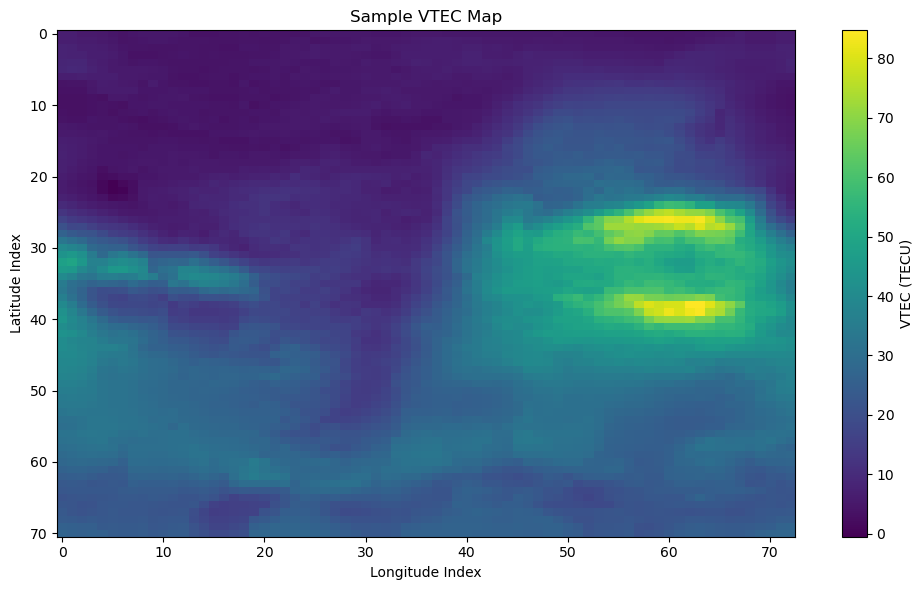

In [2]:
#open one of the files to check
import numpy as np
import os

output_folder = "/home/simone/Desktop/PhD/fdl/datasets/vtec_data_processed"
# Load a sample file to check the data
sample_file = os.path.join(output_folder, "GIM_vTEC_20230101_0630.npy")
sample_data = np.load(sample_file)/10
print(f"Sample data shape: {sample_data.shape}")
print(f"Sample data (first 5 rows):\n{sample_data[:5]}")
# Check the epochs
print(f"Sample data (first 5 columns):\n{sample_data[:, :5]}")

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.imshow(sample_data, cmap='viridis', aspect='auto')
plt.colorbar(label='VTEC (TECU)')
plt.title('Sample VTEC Map')
plt.xlabel('Longitude Index')
plt.ylabel('Latitude Index')
plt.grid(False)
plt.tight_layout()
plt.show()  


In [ ]:
import os, re, numpy as np, pandas as pd
from datetime import datetime, timedelta
from pathlib import Path

def parse_ionex_to_daily_df(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()

    header_end = [i for i, l in enumerate(lines) if 'END OF HEADER' in l][0]
    header = lines[:header_end]

    for line in header:
        if 'LAT1 / LAT2 / DLAT' in line:
            lat1, lat2, dlat = map(float, line.split()[:3])
        if 'LON1 / LON2 / DLON' in line:
            lon1, lon2, dlon = map(float, line.split()[:3])

    lats = np.arange(lat1, lat2 - 0.1, -abs(dlat))  # top-to-bottom
    lons = np.arange(lon1, lon2 + 0.1, dlon)

    maps = []
    epochs = []

    i = header_end + 1
    while i < len(lines):
        if 'START OF TEC MAP' in lines[i]:
            epoch_line = lines[i+1]
            y, mo, d, h, mi, s = map(int, epoch_line[:36].split())
            if h == 24:
                h = 0
                base_date = datetime(y, mo, d) + timedelta(days=1)
                epoch = datetime(base_date.year, base_date.month, base_date.day, h, mi, s)
            else:
                epoch = datetime(y, mo, d, h, mi, s)
            epochs.append(epoch)

            grid = []
            i += 2
            while i < len(lines) and ('START OF TEC MAP' not in lines[i]) and ('END OF FILE' not in lines[i]):
                if 'LAT/LON1/LON2/DLON/H' in lines[i]:
                    row = []
                    i += 1
                    while i < len(lines):
                        line_strip = lines[i].strip()
                        if not line_strip or not re.match(r'^[-\d\s]+$', line_strip) or 'END OF TEC MAP' in line_strip:
                            break
                        vals = [float(v) if v != '9999' else np.nan for v in line_strip.split()]
                        row.extend(vals)
                        i += 1
                    if len(row) != len(lons):
                        row = (row + [np.nan]*len(lons))[:len(lons)]
                    grid.append(row)
                else:
                    i += 1
            while len(grid) < len(lats):
                grid.append([np.nan]*len(lons))
            grid = grid[:len(lats)]
            maps.append(np.array(grid))
        else:
            i += 1

    return pd.DataFrame({"map": maps}, index=pd.DatetimeIndex(epochs))

# ────────────────────────────────────────────────────────────────

from pathlib import Path
inp = Path("/home/simone/Desktop/PhD/fdl/datasets/vtec_data")
print("files seen:", len(list(inp.glob("*"))))
print("*.i files :", len(list(inp.glob("*i"))))
print("first 5   :", [p.name for p in sorted(inp.glob("*i"))[:5]])



input_folder  = "/home/simone/Desktop/PhD/fdl/datasets/vtec_data" #change this to your input folder

for fname in os.listdir(input_folder):
    if not fname.endswith("i"):
        continue
    fpath = os.path.join(input_folder, fname)
    try:
        #print(f" parsing {fname}")
        df = parse_ionex_to_daily_df(fpath)
        df = df.iloc[:-1] # remove the last row which is the starting point of the day: to verify
        #print(" epochs parsed:", len(df))                       # DEBUG 1

        if df.empty:
            #print("DataFrame empty, skip.")
            continue

        day_str  = df.index[0].strftime("%Y%m%d")
        output_folder = f"/home/simone/Desktop/PhD/fdl/datasets/daily_vtec_data/{day_str[:4]}/{day_str[4:6]}/{day_str[6:]}" #change first part to your output folder
        Path(output_folder).mkdir(parents=True, exist_ok=True)
        #print("output folder:", output_folder)                 # DEBUG 3
        outfile  = Path(output_folder, f"vTEC_{day_str}.pkl")
        #print("saving to:", outfile)                            # DEBUG 2

        df.to_pickle(outfile, protocol=4)
        #print("written\n")                                   # DEBUG 3

    except Exception as exc:
        print(" ERROR:", exc)

files seen: 2
*.i files : 2
first 5   : ['uqrg0010.23i', 'uqrg0020.23i']


,map
2023-01-01 00:00:00,"[[86.0, 87.0, 89.0, 90.0, 89.0, 86.0, 84.0, 83..."
2023-01-01 00:15:00,"[[85.0, 87.0, 89.0, 89.0, 86.0, 83.0, 82.0, 83..."
2023-01-01 00:30:00,"[[90.0, 88.0, 88.0, 85.0, 83.0, 82.0, 81.0, 87..."
2023-01-01 00:45:00,"[[89.0, 87.0, 84.0, 83.0, 83.0, 82.0, 84.0, 85..."
2023-01-01 01:00:00,"[[87.0, 88.0, 88.0, 86.0, 91.0, 63.0, 64.0, 69..."
...,...
2023-01-01 22:45:00,"[[12.0, 17.0, 21.0, 50.0, 49.0, 48.0, 57.0, 59..."
2023-01-01 23:00:00,"[[42.0, 47.0, 57.0, 49.0, 51.0, 59.0, 60.0, 63..."
2023-01-01 23:15:00,"[[42.0, 51.0, 52.0, 55.0, 55.0, 59.0, 62.0, 65..."
2023-01-01 23:30:00,"[[52.0, 57.0, 55.0, 57.0, 58.0, 65.0, 64.0, 65..."


/tmp/ipykernel_3159/2607978163.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_at_06 = df.loc["2023-01-01 16:00"][0] # 2‑D array


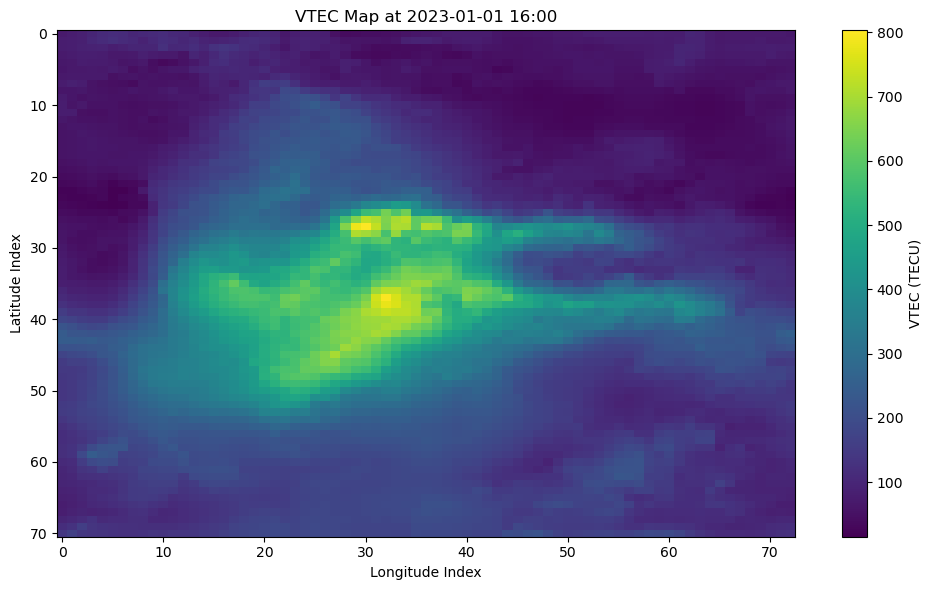

In [17]:
df = pd.read_pickle("/home/simone/Desktop/PhD/fdl/datasets/daily_vtec_data/2023/01/01/vTEC_20230101.pkl")
#remove last element of the df
#df = df.iloc[:-1]  # Remove the last row if it is not needed
display(df)
grid_at_06 = df.loc["2023-01-01 16:00"][0] # 2‑D array


import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.imshow(grid_at_06, cmap='viridis', aspect='auto')
plt.colorbar(label='VTEC (TECU)')
plt.title('VTEC Map at 2023-01-01 16:00')
plt.xlabel('Longitude Index')
plt.ylabel('Latitude Index')
plt.grid(False)
plt.tight_layout()
plt.show()